In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import contractions
import pandas as pd
import numpy as np
import os
import re
import nltk

In [2]:
text_dict = {'text':[], 'happy':[], 'sadness':[], 'fear':[], 'anger':[], 'love':[], 'surprise':[]}
emotions = ['happy', 'sadness', 'anger', 'fear', 'love', 'surprise']
def read_data(url):
    train = pd.read_csv(url)
    for index, row in train.iterrows():
        sentence = row['Text']
        emotion = row['Emotion']
        text_dict['text'].append(sentence)
        for e in emotions:
            if emotion == e:
                text_dict[emotion].append(1)
            else:
                text_dict[e].append(0)
    train = pd.DataFrame(text_dict)
    return(train)

In [3]:
train = read_data("Emotion_final.csv")
train.head()

,text,happy,sadness,fear,anger,love,surprise
0,i didnt feel humiliated,0,1,0,0,0,0
1,i can go from feeling so hopeless to so damned...,0,1,0,0,0,0
2,im grabbing a minute to post i feel greedy wrong,0,0,0,1,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,0,1,0
4,i am feeling grouchy,0,0,0,1,0,0


In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

In [5]:
def preprocess_dataframe(df):
    for index, row in df.iterrows():
        filter_sentence = ''
        sentence = row['text']
        sentence = contractions.fix(sentence)
        
        # Cleaning the sentence with regex
        sentence = re.sub(r'[^\w\s]', '', sentence)

        # Tokenization
        words = nltk.word_tokenize(sentence)

        # Stopwords removal
        words = [w for w in words if not w in stop_words]
        
        for words in words:
            filter_sentence = filter_sentence  + ' ' + str(lemmatizer.lemmatize(words)).lower()
        
        df.loc[index, 'text'] = filter_sentence
    df = df[['text', 'happy', 'sadness', 'fear', 'anger', 'love', 'surprise']]
    return(df)

In [6]:
train = preprocess_dataframe(train)

In [7]:
Y = train[['happy', 'sadness', 'fear', 'anger', 'love', 'surprise']]
Y = np.array(Y)
X = np.array(train['text'])

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_new = []
for line in X:
    token_list = tokenizer.texts_to_sequences([line])[0]
    X_new.append(token_list)
max_sequence_len = max(max([len(x) for x in X_new]), 50)
input_sequences = np.array(pad_sequences(X_new, maxlen=max_sequence_len, padding='pre'))
total_words = len(tokenizer.word_index) + 1
X = input_sequences

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [10]:
from keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout, Flatten
from keras.models import Sequential

In [11]:
model = Sequential()
model.add(Embedding(total_words, 8, input_length = X.shape[1]))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 8)             137888    
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 2406      
Total params: 140,294
Trainable params: 140,294
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = model.fit(X_train, y_train, epochs = 30)

Epoch 1/30
537/537 [==============================] - 1s 2ms/step - loss: 1.5564 - accuracy: 0.3887
Epoch 2/30
537/537 [==============================] - 1s 2ms/step - loss: 1.1037 - accuracy: 0.6642
Epoch 3/30
537/537 [==============================] - 1s 2ms/step - loss: 0.6150 - accuracy: 0.8384
Epoch 4/30
537/537 [==============================] - 1s 2ms/step - loss: 0.3710 - accuracy: 0.9074
Epoch 5/30
537/537 [==============================] - 1s 2ms/step - loss: 0.2451 - accuracy: 0.9443
Epoch 6/30
537/537 [==============================] - 1s 3ms/step - loss: 0.1733 - accuracy: 0.9604
Epoch 7/30
537/537 [==============================] - 2s 3ms/step - loss: 0.1298 - accuracy: 0.9710
Epoch 8/30
537/537 [==============================] - 2s 3ms/step - loss: 0.1011 - accuracy: 0.9774
Epoch 9/30
537/537 [==============================] - 1s 3ms/step - loss: 0.0817 - accuracy: 0.9816
Epoch 10/30
537/537 [==============================] - 1s 2ms/step - loss: 0.0671 - accuracy: 0.9853

In [13]:
def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

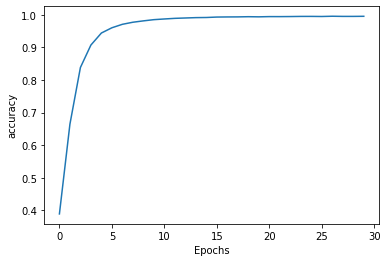

In [14]:
plot_graph(history,'accuracy')

In [15]:
# # Save the trained model

# # serialize to JSON
# json_file = model.to_json()
# with open("model.json", "w") as file:
#    file.write(json_file)
# # serialize weights to HDF5
# model.save_weights("model.h5")

In [16]:
# # Load the saved model

# from keras.models import model_from_json

# # load json and create model
# file = open('model.json', 'r')
# model_json = file.read()
# file.close()
# loaded_model = model_from_json(model_json)
# # load weights
# loaded_model.load_weights("model.h5")

In [17]:
def preprocess_sentence(sentence):
    sentence = contractions.fix(sentence)
    sentence = re.sub(r'[^\w\s]', '', sentence)
    
    words = nltk.word_tokenize(sentence)
    words = [w for w in words if not w in stop_words]
    
    filter_sentence = ''
    for words in words:
        filter_sentence = filter_sentence  + ' ' + str(lemmatizer.lemmatize(words)).lower()
        
    return(filter_sentence)

In [18]:
def detect(text):
    text = preprocess_sentence(text)
    token_list = tokenizer.texts_to_sequences([text])[0]
    zeros = max(0, max_sequence_len - len(token_list))
    token_list = [0]*zeros + token_list
    token_list = np.array(token_list).reshape(1, max_sequence_len)
    index = np.argmax(model.predict(token_list), axis = -1)[0]
    
    emotions = ['happy', 'sadness', 'fear', 'anger', 'love', 'surprise']
    return(emotions[index])

In [19]:
detect("I feel tired, sore, and lonely. I just want somebody to hold")

'sadness'

In [20]:
detect("Not great. I feel suicidal and I have no one to talk to")

'happy'

In [21]:
y_pred = np.argmax(model.predict(X_test), axis = -1)

In [22]:
y_test = [list(i).index(1) for i in list(y_test)]
y_test = np.array(y_test)

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print("Accuracy of model on test set:")
print(accuracy_score(y_test, y_pred))
print("\nThe confusion matrix on test set")
print(confusion_matrix(y_test, y_pred))

Accuracy of model on test set:
0.8140726933830382

The confusion matrix on test set
[[1239   57   18   21   48   10]
 [  70 1065   35   38   12    3]
 [  36   57  379   30    8   22]
 [  52   64   18  491    6    2]
 [  87   17    5    9  220    1]
 [  26   17   19    9    1  100]]
